In [98]:
#####
#preliminary functions
#####

using Printf
using Plots

######
#WA mc routine

const L       = 10             # linear size of lattice
const temps   = 6.0:-0.3:0.1  # temperatures to sample
const nt = length(temps)      #number of temperatures
#the 4 different bond directions on the lattice
const dir_list = [[1,0], [0,1], [-1,0], [0,-1]] 

function sweep(nv, ratio, all_map) 
    
    i = 0

    while i <= nv
        #pick a I = M site
        Ix = 2*rand(1:L)
        Iy = 2*rand(1:L)
        Mx = Ix
        My = Iy
        cond = true
        while cond
            #choose a bond direction
            dir_link = dir_list[rand(1:4)]
            link_x = 1 + mod(Mx - 1 + dir_link[1], 2*L)
            link_y = 1 + mod(My - 1 + dir_link[2], 2*L)
            link_val = all_map[link_x, link_y]
            #random number and acceptance test
            p = rand()
            barrier = minimum([1, ratio^(1 - 2*link_val)])
            if (p < barrier)
                all_map[link_x, link_y] = 1 - link_val
                Mx = 1 + mod(Mx - 1 + 2*dir_link[1], 2*L)
                My = 1 + mod(My - 1 + 2*dir_link[2], 2*L)
                i += 1
                #display("accept")
            end

            cond = !(Ix == Mx && Iy == My)
            #print(" ", cond, "\n")
        end
    end
end

#testing
#all_map_test = sweep(10, 0.9, zeros(Int32,2*10,2*10))
#it is nonzero = it works


function measureWorm(ratio, all_map)
    #pick a I = M site
    Ix = 2*rand(1:L)
    Iy = 2*rand(1:L)
    Mx = Ix
    My = Iy

    dist_M_to_I = [0,0] 
    g_map_temp = zeros(Int32, L, L) 
    cond = true
    while cond
        #choose a bond direction
        dir_link = dir_list[rand(1:4)]
        link_x = 1 + mod(Mx - 1 + dir_link[1], 2*L)
        link_y = 1 + mod(My - 1 + dir_link[2], 2*L)
        link_val = all_map[link_x, link_y]
        #random number and acceptance test
        p = rand()
        barrier = minimum([1, ratio^(1 - 2*link_val)])
        if (p < barrier)
            all_map[link_x, link_y] = 1 - link_val
            Mx = 1 + mod(Mx - 1 + 2*dir_link[1], 2*L)
            My = 1 + mod(My - 1 + 2*dir_link[2], 2*L)
            dist_M_to_I += dir_link
            g_x = 1 + mod(dist_M_to_I[1], L)
            g_y = 1 + mod(dist_M_to_I[2], L)
            g_map_temp[g_x, g_y] += 1
        end

        cond = !(Ix == Mx && Iy == My)

    end 
    
    #g_map_temp = mod.(g_map_temp, 2) #remove doubly or triply visited sites from the count of G
    #this ended up being the wrong idea
    return g_map_temp
end

measureWorm (generic function with 2 methods)

In [18]:
#test
all_map = zeros(Int32, 2*L, 2*L)
sweep(200, 0.6, all_map)
v1 = sum(all_map)

g_map = zeros(Int32, L, L)
g_map += measureWorm(0.9, all_map, g_map)
v2 = sum(all_map)
display(g_map)

42

In [94]:
######
#WA mc routine
#####

n_sweep = L^2             # number of sweeps between sampling
n_therm = 2000*L^2           # number of sweeps to thermalize
n_data  = 2000            # number of data samples per temperature

#empty lists of measures to fill
et = []                  # array to append average energy at each T
chi = []                 # "                      susceptibility
cv = []                 # "                      specific heat
nlink = []               # "                      number of active bonds
#store the correlation function G(I - M) for all temperatures
g_maps = zeros(Int32, L, L, nt)

#initialize the configuration - double the number of indices, bonds live on even indices
all_map = zeros(Int32,2*L, 2*L) 

for ti in 1:nt              # loop over temperatures
    T = temps[ti]
    β = 1/T
    ratio = (tanh(β))
    
    bonds_list = zeros(Float64, n_data)
    ene_list = zeros(Float64, n_data)
    mag_list = zeros(Float64, n_data)
    g_maps_temperature = zeros(Int32, L, L)
    
    #initialize the starting configuration as either the zero-filled one
    #or the last map obtained after the measurements from the previous high-temperature
    sweep(n_therm, ratio, all_map)    # thermalize the lattice
    for i = 1:n_data        # take n_data measurements w/ n_sweep 
        sweep(n_sweep, ratio, all_map)   
        g_meas = measureWorm(ratio, all_map)
        g_maps_temperature += g_meas
        ene_list[i] = (g_meas[1,2] + g_meas[2,1]+ g_meas[1,L] + g_meas[L,1])/(2)
        mag_list[i] = sum(g_meas)
        bonds_list[i] = sum(all_map)
    end
    
    g_maps[:,:,ti] = g_maps_temperature
    num_Z = g_maps_temperature[1,1]
    en_ave = sum(ene_list)/num_Z
    cv_ave = sqrt(sum((ene_list .- en_ave).^2) / (num_Z - 1))
    push!(et,-en_ave)                # add to the list    
    push!(cv, cv_ave)                # add to the list
    chi_ave = sum(mag_list)/num_Z
    push!(chi, chi_ave)
    #display(g_map/num_Z)
    @printf("%8.3f  %8.3f \n", T, -en_ave)
    flush(stdout)
end

   6.000    -0.395 
   5.700    -0.386 
   5.400    -0.403 
   5.100    -0.402 
   4.800    -0.374 
   4.500    -0.399 
   4.200    -0.395 
   3.900    -0.423 
   3.600    -0.410 
   3.300    -0.455 
   3.000    -0.433 
   2.700    -0.485 
   2.400    -0.540 
   2.100    -0.608 
   1.800    -0.620 
   1.500    -0.666 
   1.200    -0.687 
   0.900    -0.664 
   0.600    -0.676 
   0.300    -0.675 


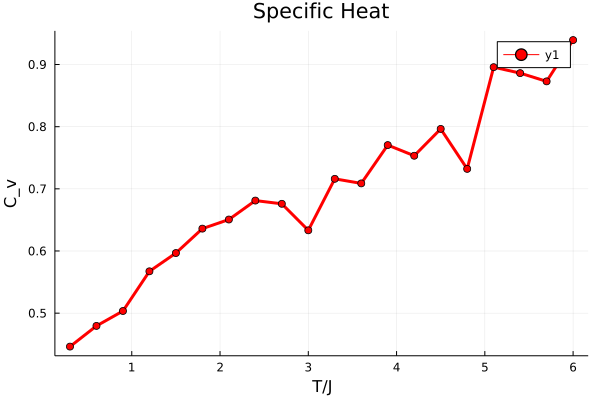

In [96]:
plot(temps, cv, title = "Specific Heat", lw = 3, shape = :circle, color = :red, markersize = 4)
xlabel!("T/J")
ylabel!("C_v")


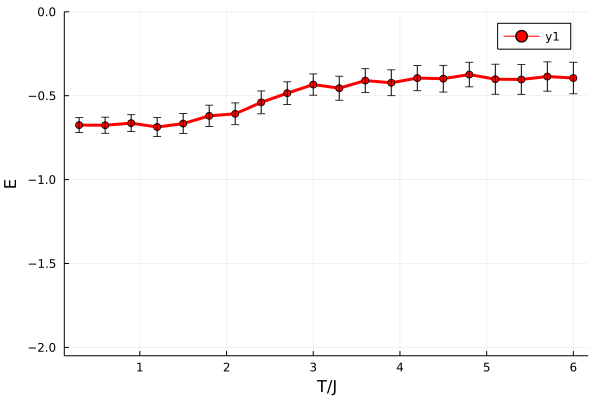

In [95]:
plot(temps, et, yerr = cv/L, lw = 3, shape = :circle, color = :red, markersize = 4, ylims = (-2.05, 0))
xlabel!("T/J")
ylabel!("E")

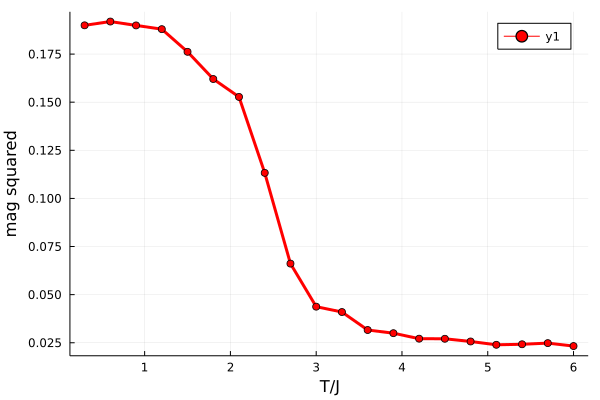

In [97]:
plot(temps, chi/L^2, lw = 3, shape = :circle, color = :red, markersize = 4)
xlabel!("T/J")
ylabel!("mag squared")

In [ ]:
#######
#practice code
#######

L       = 10             # linear size of lattice
hL = Int(L/2)
#n_sweep = 20             # number of sweeps between sampling
n_therm = 1000           # number of sweeps to thermalize
n_meas  = 5000            # number of data samples per temperature
temps   = 8.0:-0.3:0.1;   # temperatures to sample
nt = length(temps)

e1 = Array(1:n_data)     # array to hold energy measurements (fixed T)
m1 = Array(1:n_data)     # array to hold magnetization measurements (fixed T)
et = []                  # array to append average energy at each T
mt = []                  # "                      magnetizations
chi = []

nlink = []
#sites = zeros(Int32,L, L) 
#bonds = zeros(Int32,2*L, 2*L) 
#bond2site = zeros(Int32,2*L, 2*L, 2) 
#site2bond = zeros(Int32, L, L, 4) 

g_maps = zeros(Int32, L, L, nt)

all_map = zeros(Int32,2*L, 2*L) #g_map = zeros(Int32,L, L) 
#g_count = zeros(Int32,L, L) 
#β = 10
dir_list = [[1,0], [0,1], [-1,0], [0,-1]] 

#list_visit_x = []
#list_visit_y = []

for ti in 1:nt              # loop over temperatures
    T = temps[ti]
    β = 1/T
    ratioB = (tanh(β))
    
    
    
    #g_count = zeros(Int32,L, L) 
    
    ####
    #thermalization
    ####

    therm = n_therm*L^2
    i = 0
    
    all_map_therm = all_map

    while i <= therm
        
        #println("doing iter #", i)
        #pick a I = M site
        Ix = 2*rand(1:L)
        Iy = 2*rand(1:L)
        #all_map[Ix, Iy] = -1  #to see visited sites
        #print("x,y = ", [Ix, Iy], "\n")

        Mx = Ix
        My = Iy

        cond = true

        while cond
            dir_link = dir_list[rand(1:4)]

            link_x = 1 + mod(Mx - 1 + dir_link[1], 2*L)
            link_y = 1 + mod(My - 1 + dir_link[2], 2*L)
            link_val = all_map_therm[link_x, link_y]
            #print("link considered ", [link_x, link_y], "\n")

            p = rand()
            barrier = minimum([1, ratioB^(1 - 2*link_val)])
            if (p < barrier)
                all_map_therm[link_x, link_y] = 1 - link_val
                Mx = 1 + mod(Mx - 1 + 2*dir_link[1], 2*L)
                My = 1 + mod(My - 1 + 2*dir_link[2], 2*L)
                i += 1
            end

            cond = !(Ix == Mx && Iy == My)
            #print(" ", cond, "\n")
        end
    end

    ######
    #some measurement
    ######

    maxiter = n_meas*L^2

    val_prod = 1.0
    N_bond = 0
    i = 0
    #num_Z = 0
    g_map = zeros(Int32,L, L) 
        
    while i<=maxiter
        
        all_map = all_map_therm
        #println("doing iter #", i)
        #pick a I = M site
        Ix = 2*rand(1:L)
        Iy = 2*rand(1:L)
        #all_map[Ix, Iy] = -1  #to see visited sites
        #print("x,y = ", [Ix, Iy], "\n")

        Mx = Ix
        My = Iy
        
        dist_M_to_I = [0,0] 

        cond = true
        
        g_map_visit = zeros(Int32,L, L) 

        while cond
            N_bond_in = 0
            dir_link = dir_list[rand(1:4)]

            link_x = 1 + mod(Mx - 1 + dir_link[1], 2*L)
            link_y = 1 + mod(My - 1 + dir_link[2], 2*L)
            link_val = all_map[link_x, link_y]
            #print("link considered ", [link_x, link_y], "\n")

            p = rand()
            barrier = minimum([1, (tanh(β))^(1 - 2*link_val)])
            if (p < barrier)
                all_map[link_x, link_y] = 1 - link_val
                Mx = 1 + mod(Mx - 1 + 2*dir_link[1], 2*L)
                My = 1 + mod(My - 1 + 2*dir_link[2], 2*L)
                dist_M_to_I += dir_link
                g_x = 1 + mod(dist_M_to_I[1], L)
                g_y = 1 + mod(dist_M_to_I[2], L)
                
                #g_x = Int(mod(Ix/2 - Mx/2 + 1, L + 1))
                #g_y = Int(mod(Iy/2 - My/2 + 1, L + 1))
                g_map_visit[g_x, g_y] += 1
                if g_map_visit[g_x,g_y] == 1
                    g_map[g_x, g_y] += 1
                end
                i += 1
                N_bond_in += 1
                #println("updated link ")
                #all_map[Mx, My] = -1 #to see visited sites
                #val_prod = val_prod*(tanh(β))^(1 - 2*link_val)
                #masha - ira
                #vec = distance([Ix,Iy], [Mx, My])
                #g_map[1+vec[1], 1+vec[2]] += val_prod
                #g_count[1+vec[1], 1+vec[2]] += 1.0



                #push!(list_visit_x, Mx)
                #push!(list_visit_y, My)
            end

            cond = !(Ix == Mx && Iy == My)
            #print(" ", cond, "\n")
            
            #if cond == false && N_bond_in != 0
            #    num_Z += 1
            #end
        end
        
        N_bond += sum(all_map)
    end

    num_Z = g_map[1,1]
    push!(nlink, N_bond/num_Z)
    en_ave = (g_map[1,2] + g_map[2,1] + g_map[1,L] + g_map[L,1])/(2*num_Z) 
    push!(et,-en_ave)                # add to the list
    push!(chi, sum(g_map)/maxiter)
    
    display(g_map/num_Z)
    g_maps[:,:,ti] = g_map
    @printf("%8.3f  %8.3f \n", T, -en_ave)
    flush(stdout)

end
